# Data Preparation Pipeline

Prepare data in order to do training and prediction. 

The output of this is a set of descriptors with corresponding lables. 

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt 

def gaussian(I, sigma):
    """
    Applies a 2-D Gaussian blur with standard deviation sigma to
    a grayscale image I.
    """
    h = int(np.ceil(3*sigma))
    x = np.linspace(-h, +h, 2*h + 1)
    g = np.exp(-x**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
    Ig = np.zeros_like(I)
    for row in range(I.shape[0]): Ig[row,:] = np.convolve(I[row,:], g, mode='same')
    for col in range(I.shape[1]): Ig[:,col] = np.convolve(Ig[:,col], g, mode='same')
    return Ig

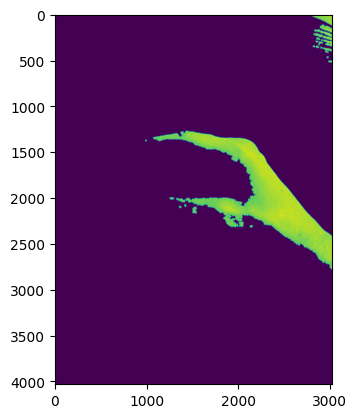

In [5]:
I = cv.imread("./data/raw/img/openHand/IMG_4410.JPG", cv.IMREAD_GRAYSCALE)

##I = cv.threshold(I, 170, 255, cv.THRESH_BINARY)[1]

lower = np.array([160])
upper = np.array([255])
thresh = cv.inRange(I, lower, upper)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20,20))
morph = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
result = cv.bitwise_and(I, I, mask=morph)

plt.imshow(result)


In [61]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import cv2 as cv

nfeatures = 800

orb = cv.ORB_create(nfeatures=nfeatures)

open_descriptors = []
open_keypoints = []

num_images = 0

thresh = 127

lower = np.array([160])
upper = np.array([255])

path_open = "./data/raw/img/openHand/"
path_closed = "./data/raw/img/closedHand/"

## RETRIEVING OPEN HAND DESCRIPTORS 

for image in os.listdir(path_open): 

    num_images += 1 
    
    I = cv.imread(path_open + image, cv.IMREAD_GRAYSCALE)
    #I = cv.threshold(I, thresh, 255, cv.THRESH_BINARY)[1]

    thresh = cv.inRange(I, lower, upper)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20,20))
    morph = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    I = cv.bitwise_and(I, I, mask=morph)

    

    kp = orb.detect(I)
    kp, des = orb.compute(I, kp)

    if (des.shape[0] > nfeatures) : 

        n = np.abs(des.shape[0] - nfeatures)
        des = np.delete(des, np.arange(nfeatures, nfeatures+n, 1), 0)
        kp = np.delete(kp, np.arange(nfeatures, nfeatures+n, 1), 0)

    

    # img_ = cv.drawKeypoints(I, kp, None, color=(0,255,0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # plt.imshow(img_), plt.show()
    open_descriptors.append(des)
    open_keypoints.append(kp)

## RETRIEVING CLOSED HAND DESCRIPTORS
    
thresh = 127

for image in os.listdir(path_closed): 

    num_images += 1 
    
    I = cv.imread(path_closed + image, cv.IMREAD_GRAYSCALE)
    # I = cv.threshold(I, thresh, 255, cv.THRESH_BINARY)[1]
    thresh = cv.inRange(I, lower, upper)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20,20))
    morph = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    I = cv.bitwise_and(I, I, mask=morph)

    kp = orb.detect(I)
    kp, des = orb.compute(I, kp)

    if (des.shape[0] > nfeatures) : 

        n = np.abs(des.shape[0] - nfeatures)
        des = np.delete(des, np.arange(nfeatures, nfeatures+n, 1), 0)
        kp = np.delete(kp, np.arange(nfeatures, nfeatures+n, 1), 0)

    

    # img_ = cv.drawKeypoints(I, kp, None, color=(0,255,0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # plt.imshow(img_), plt.show()
    open_descriptors.append(des)
    open_keypoints.append(kp)

all_descriptors = []

for descriptors in open_descriptors: 
    for descriptor in descriptors: 
        all_descriptors.append(descriptor)



all_descriptors = np.stack(all_descriptors, dtype=float)
all_descriptors.shape

    

(94400, 32)

# K-Means Pipeline

Utilize k-means in order to create e image-vocabulary for later trainign to recognize hand gesture.

In [70]:
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq

n_clusters = 500
iters = 1
codebook, variance = kmeans(all_descriptors, n_clusters, iters, seed=42) 



In [71]:
visualWords = [] 

for img_descriptors in open_descriptors: 
    img_descriptors = img_descriptors.astype(float)
    img_visual_words, distance = vq(img_descriptors, codebook)
    visualWords.append(img_visual_words)



In [72]:
visualWords[0][:5], len(codebook)

(array([158,  92,  62, 102, 126], dtype=int32), 200)

In [73]:
frequency_vectors = []

for img_visual_words in visualWords: 
    img_freq_vec = np.zeros(n_clusters)

    for word in img_visual_words: 
        img_freq_vec[word] += 1
    
    frequency_vectors.append(img_freq_vec)


frequency_vectors = np.stack(frequency_vectors)


In [74]:
frequency_vectors.shape

(118, 200)

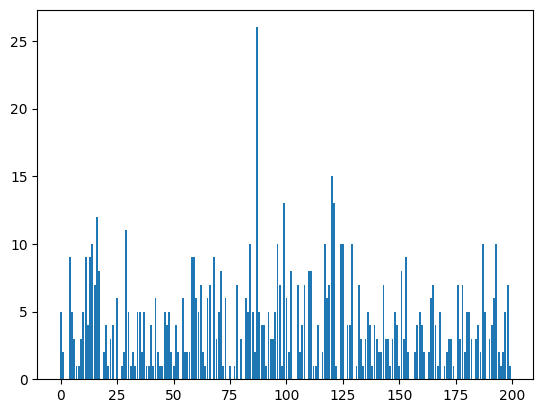

In [75]:
plt.bar(list(range(n_clusters)), frequency_vectors[31])
plt.show()

# SVM Pipeline 

This part uses Support Vector Machine to train on the dictionary. 


In [76]:
from sklearn.svm import SVC
from sklearn.utils import shuffle
y = np.ones((118, ))
y[:63] = 0

X, y= shuffle(frequency_vectors, y, random_state=42)

svc = SVC(random_state=42)
svc.fit(X, y)

frequency_vectors.shape

(118, 200)

## Testing on training set


### Open hand images

In [77]:

preds = []

for image in os.listdir(path_open): 
    I_test = cv.imread(path_open+image, cv.IMREAD_GRAYSCALE)
    lower = np.array([160])
    upper = np.array([255])
    thresh = cv.inRange(I_test, lower, upper)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20,20))
    morph = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    I_test = cv.bitwise_and(I_test, I_test, mask=morph)

    kp = orb.detect(I_test)
    kp, des = orb.compute(I_test, kp)
    test_visual_words, distance = vq(des, codebook)
    img_freq_vec = np.zeros(n_clusters)

    for word in test_visual_words: 
        img_freq_vec[word] += 1
    
    pred = svc.predict(img_freq_vec.reshape(1, -1))
    preds.append(pred)

    

    


In [78]:
(len(preds)-np.count_nonzero(np.array(preds)))/len(preds)


1.0

### Closed hand testing


In [79]:
preds = []

for image in os.listdir(path_closed): 
    I_test = cv.imread(path_closed+image, cv.IMREAD_GRAYSCALE)
    lower = np.array([160])
    upper = np.array([255])
    thresh = cv.inRange(I_test, lower, upper)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20,20))
    morph = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    I_test = cv.bitwise_and(I_test, I_test, mask=morph)

    kp = orb.detect(I_test)
    kp, des = orb.compute(I_test, kp)
    test_visual_words, distance = vq(des, codebook)
    img_freq_vec = np.zeros(n_clusters)

    for word in test_visual_words: 
        img_freq_vec[word] += 1
    
    pred = svc.predict(img_freq_vec.reshape(1, -1))
    preds.append(pred)

    


In [80]:
(np.count_nonzero(np.array(preds)))/len(preds)


1.0

# Testing on new images

Pipeline for new images 

1. Use ORB to extract features
2. feed these descriptors into the trained kmeans to cluster this gives us the visual words in that new image 
3. we create the frequency vector from the visual words, counting how many instanses of each word in our dictionary we encounter. 
4. use the SVM to predict which gesture

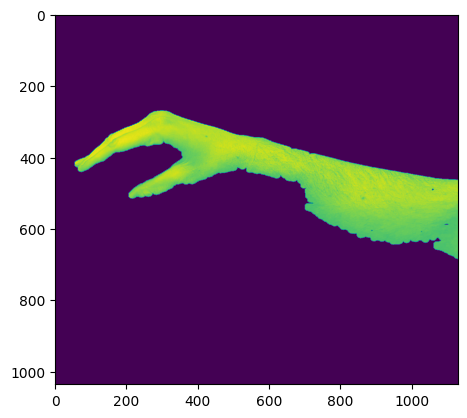

(<matplotlib.image.AxesImage at 0x297e323b0>, None)

In [ ]:
# loading image, imagine this coming from webcam 
import cv2
import matplotlib.pyplot as plt

I_test = cv2.imread("./data/raw/img/open2.png", cv.IMREAD_GRAYSCALE)
lower = np.array([160])
upper = np.array([255])
thresh = cv.inRange(I_test, lower, upper)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20,20))
morph = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
I_test = cv.bitwise_and(I_test, I_test, mask=morph)
plt.imshow(I_test), plt.show()


In [ ]:
kp = orb.detect(I_test)
kp, des = orb.compute(I_test, kp)

In [ ]:

test_visual_words, distance = vq(des, codebook)

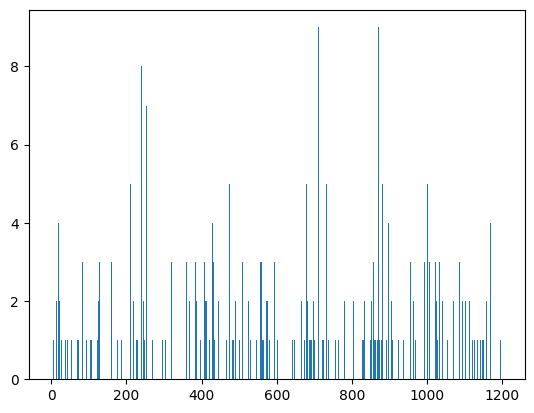

(1200,)

In [ ]:
img_freq_vec = np.zeros(n_clusters)

for word in test_visual_words: 
    img_freq_vec[word] += 1

plt.bar(list(range(n_clusters)), img_freq_vec)
plt.show()


img_freq_vec.shape

In [ ]:
pred = svc.predict(img_freq_vec.reshape(1, -1))

pred

array([0.])

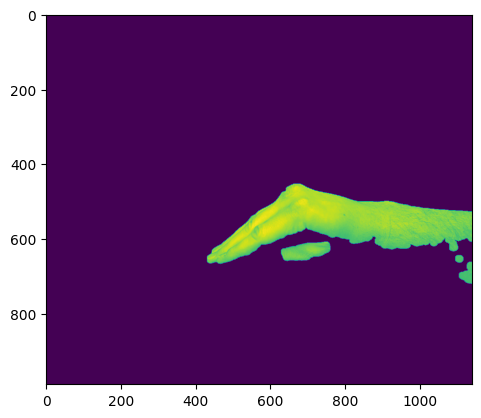

(<matplotlib.image.AxesImage at 0x29770dde0>, None)

In [ ]:
# loading image, imagine this coming from webcam 
import cv2
import matplotlib.pyplot as plt

I_test = cv2.imread("./data/raw/img/lukka2.png", cv.IMREAD_GRAYSCALE)
lower = np.array([160])
upper = np.array([255])
thresh = cv.inRange(I_test, lower, upper)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20,20))
morph = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
I_test = cv.bitwise_and(I_test, I_test, mask=morph)
plt.imshow(I_test), plt.show()

In [ ]:
kp = orb.detect(I_test)
kp, des = orb.compute(I_test, kp)

In [ ]:
test_visual_words, distance = vq(des, codebook)

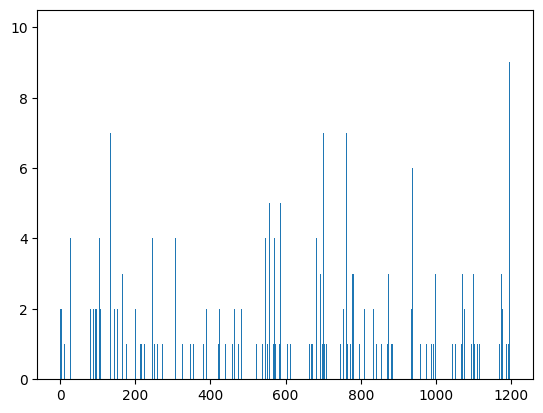

(1200,)

In [ ]:
img_freq_vec = np.zeros(n_clusters)

for word in test_visual_words: 
    img_freq_vec[word] += 1

plt.bar(list(range(n_clusters)), img_freq_vec)
plt.show()
img_freq_vec.shape

In [1]:
pred = svc.predict(img_freq_vec.reshape(1, -1))

pred



NameError: name 'svc' is not defined

# Testing in video 

In [15]:
import cv2 as cv
import numpy as np 

frameWidth = 450
frameHeight = 640
cap = cv.VideoCapture(1)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10,150)

counters = []

while True:

    success, img = cap.read()
 
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    lower = np.array([160])
    upper = np.array([255])
    thresh = cv.inRange(img, lower, upper)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20,20))
    morph = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    I = cv.bitwise_and(img, img, mask=morph)


    kp = orb.detect(I)
    kp, des = orb.compute(I, kp)

    if ( kp or des): 

        test_visual_words, distance = vq(des, codebook)

        img_freq_vec = np.zeros(n_clusters)

        for word in test_visual_words: 
            img_freq_vec[word] += 1

        pred = svc.predict(img_freq_vec.reshape(1, -1))

        counters.append(pred)
        if len(counters) > 10: 
            counters.pop(0)

        avg_pred = sum(counters)/len(counters)

        print(round(avg_pred[0]))
    

    cv.imshow("Result", I)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1


KeyboardInterrupt: 

: 